# **Классификация: Логистическая регрессия и SVM**

Необходимо решить задачу классификации физических лиц по уровню дохода. Данные для обучения модели хранятся в файле adult.csv, который можно найти в материалах или скачать с сайта.

Целевая переменная – уровень дохода income, который принимает два значения <=50K и >50K, поэтому классификация бинарная. Остальные признаки описывают персональную информацию – возраст, образование, семейное положение и т. д. Подробное описание признаков и их возможные значения можно получить самостоятельно, используя функции Python3 для анализа датасета (describe, unique и т.д) или прочитать информацию по [ссылке](https://www.cs.toronto.edu/~delve/data/adult/desc.html).

Задачу классификации нужно решить при помощи обучения модели логистической регрессии и модели опорных векторов.


***Этапы работы:***


1.   Получить данные и загрузить их в рабочую среду;
2.   Провести первичный анализ данных;
3.   Проверить данные на пропуски. Удалить в случае обнаружения. *Предложить альтернативный способ работы с пропусками;
4.   Построить 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака);
5.   Преобразовать категориальные признаки;
6.   Разделить выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое;
7.   Обучить модели логистической регрессии и опорных векторов на обучающем множестве;
8.   Для тестового множества предсказать уровень дохода и сравнить с истинным значением, посчитав точность предсказания моделей. Для этого будет использована встроенная функция score;
9.   Сформулировать выводы по проделанной работе;
10.  Кратко описать какие преобразования были сделаны с данными;
11.  Сравнить точность двух моделей;
12.  Написать свое мнение, в полной ли мере модели справились с поставленной задачей. *Что возможно сделать, чтобы улучшить результат?















# ***Импорт библиотек***

Импорт библиотеки для работы с данными

In [ ]:
import pandas as pd

Импорт библиотек для визуализации данных

In [ ]:
!pip install missingno


import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
%matplotlib inline

Импорт библиотек для обучения моделей

In [ ]:
!pip install optuna
!pip install catboost


import optuna
import numpy as np
from sklearn.svm import SVC
from optuna.visualization import plot_optimization_history
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


**Палитра для визуализации**

In [ ]:
dracula_palette = {
    'background': '#282a36',
    'current_line': '#44475a',
    'selection': '#44475a',
    'foreground': '#f8f8f2',
    'comment': '#6272a4',
    'cyan': '#8be9fd',
    'green': '#50fa7b',
    'orange': '#ffb86c',
    'pink': '#ff79c6',
    'purple': '#bd93f9',
    'red': '#ff5555',
    'yellow': '#f1fa8c'
}


sns.set(rc={'axes.facecolor': dracula_palette['background'], 'figure.facecolor': dracula_palette['background']})
sns.set_palette([dracula_palette['cyan'], dracula_palette['green'], dracula_palette['orange'], dracula_palette['pink'], dracula_palette['purple'], dracula_palette['red'], dracula_palette['yellow']])


plt.rcParams['text.color'] = dracula_palette['foreground']
plt.rcParams['axes.labelcolor'] = dracula_palette['foreground']
plt.rcParams['xtick.color'] = dracula_palette['foreground']
plt.rcParams['ytick.color'] = dracula_palette['foreground']

# ***Получение и загрузка данных***

Данный набор данных взят из репозитория баз данных машинного обучения UCI. Задача состоит в том, чтобы предсказать, превышает ли годовой доход человека 50 000 долларов, основываясь на данных переписи населения

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/vonexel/-/refs/heads/master/adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Исходя из [источника](https://www.cs.toronto.edu/~delve/data/adult/adultDetail.html) :



1.   age - возраст;
2.   workclass - трудовой класс человека;
3.   fnlwgt - вес выборки;
4.   education - степень образования;
5.   education-num - число степеней;
6.   marital-status - брачные узы;
7.   occupation - род занятий
8.   relationship - семейное положение;
9.   race - раса;
10.  gender - пол;
11.  capital-gain - прирост капитала;
12.  capital-loss - расходы капитала (потеря капитала);
13.  hours-per-week - кол-во рабочих часов в неделю;
14.  native-country - отечество, родная страна;
15.  income - доход.





In [ ]:
df.tail()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
48841,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


# ***Первичный анализ данных***

In [ ]:
df.shape

(48842, 15)

Данные содержат:



*   **48842 - строк, включая пропуски**;
*   **15 столбцов**.

In [ ]:
df.describe(include='all')

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
count,48842.000000,48842,4.884200e+04,48842,48842.000000,48842,48842,48842,48842,48842,48842.000000,48842.000000,48842.000000,48842,48842
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33906,NaN,15784,NaN,22379,6172,19716,41762,32650,NaN,NaN,NaN,43832,37155
mean,38.643585,NaN,1.896641e+05,NaN,10.078089,NaN,NaN,NaN,NaN,NaN,1079.067626,87.502314,40.422382,NaN,NaN
std,13.710510,NaN,1.056040e+05,NaN,2.570973,NaN,NaN,NaN,NaN,NaN,7452.019058,403.004552,12.391444,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.175505e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.781445e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.376420e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


Данные представляют собой выборку из 48842 человек, характеризующихся различными демографическими, социально-экономическими и профессиональными признаками.

Признак fnlwgt (вес выборки), может быть неинформативными для последующего анализа

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Всего 15 признаков, в данных есть пропуски, обозначенные '?' знаком, всего 48842 строк

# ***Построим матрицу корреляции***

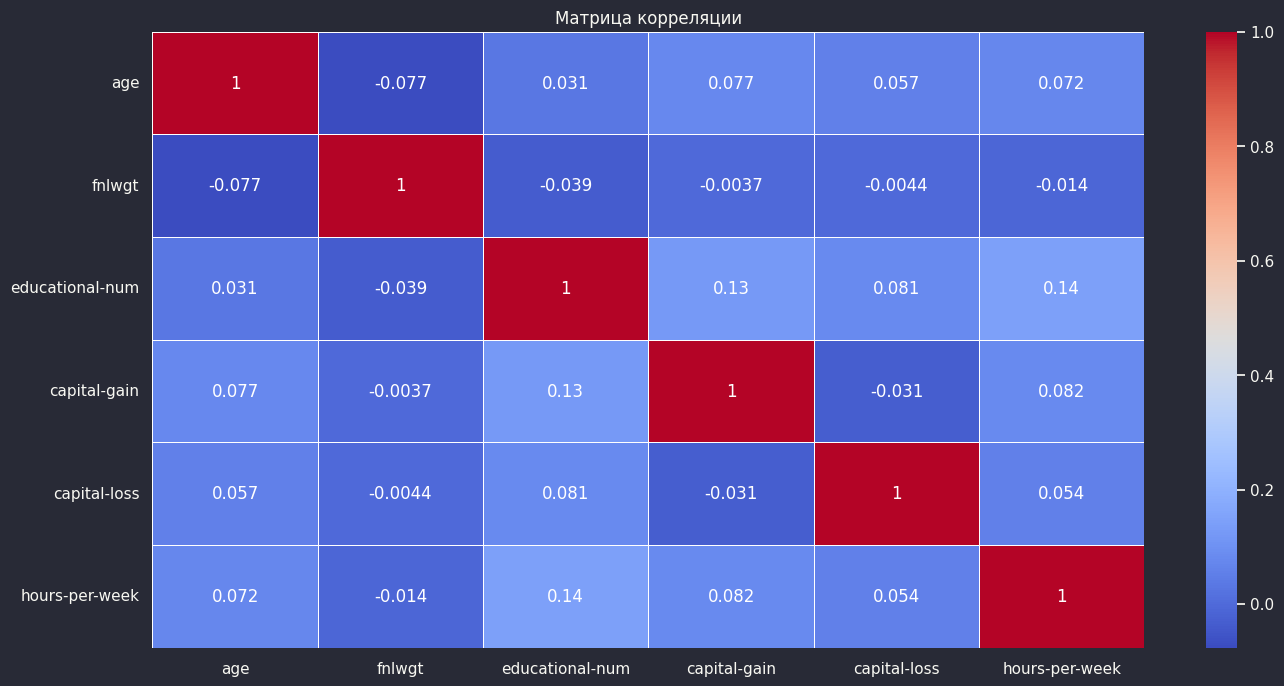

In [ ]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(16, 8))
corr_matrix = numeric_df.corr()
plt.title('Матрица корреляции')
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.show();

В данной матрице отсутствуют сильные положительные или отрицательные корреляции (значения близкие к 1 или -1). Все значения корреляций находятся в диапазоне от -0.077 до 0.14, что указывает на слабые связи между признаками, что в свою очередь свидетельствует о минимальном риске мультиколлинеарности

# ***Исследование данных, работа с пропусками, визуализация данных***

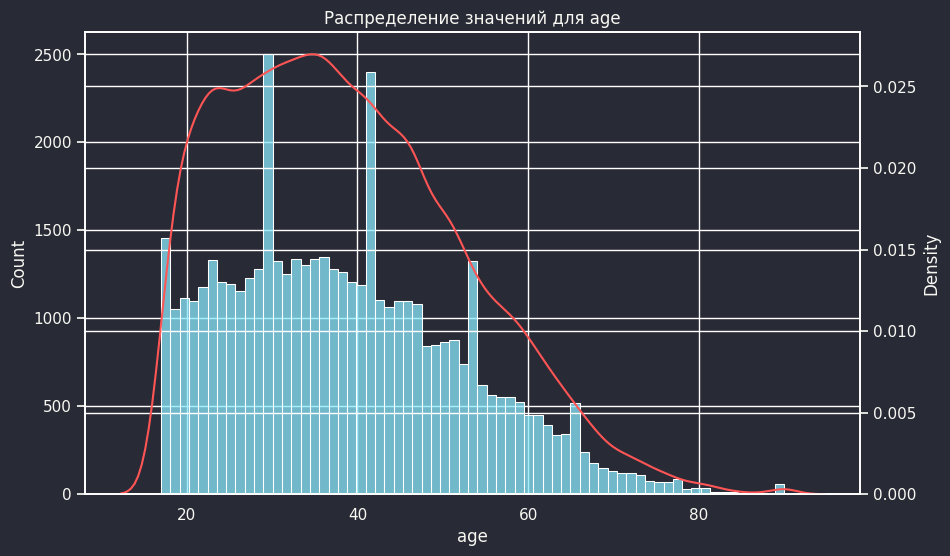

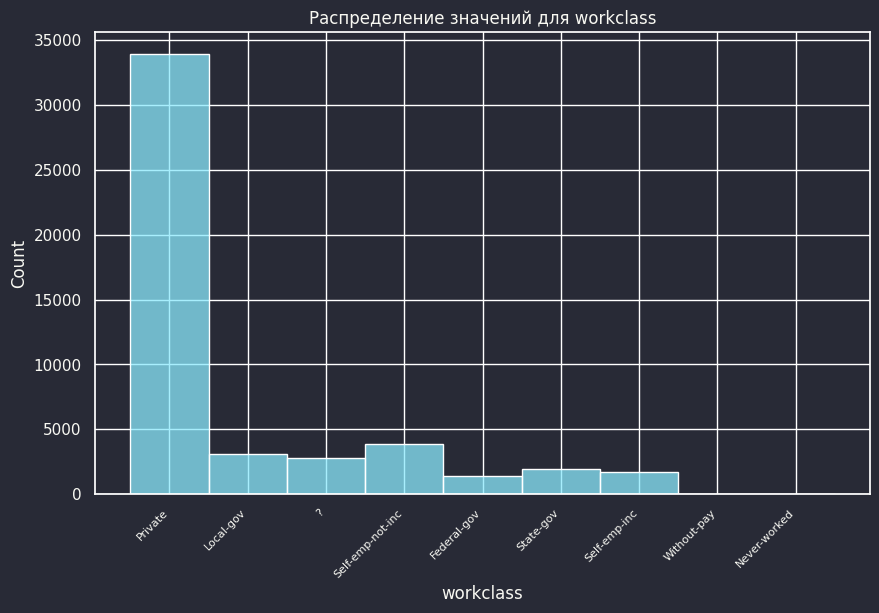

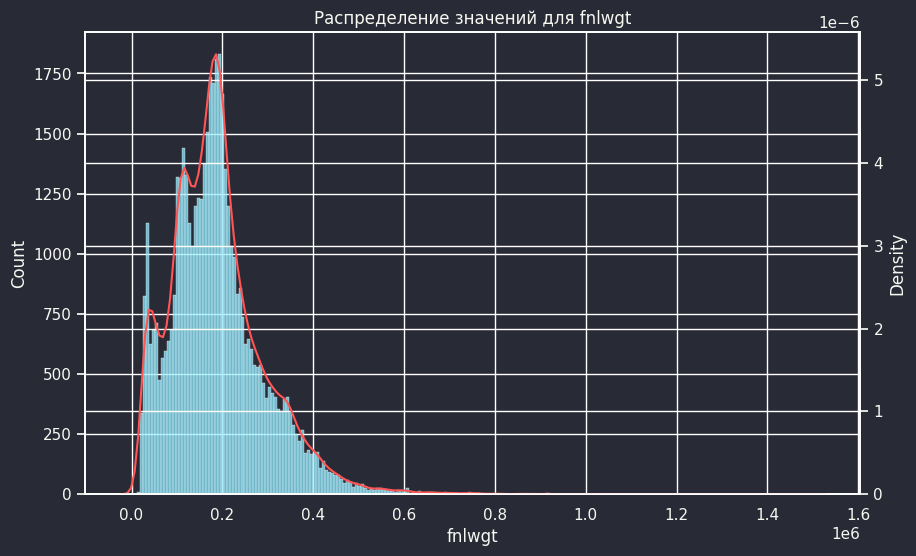

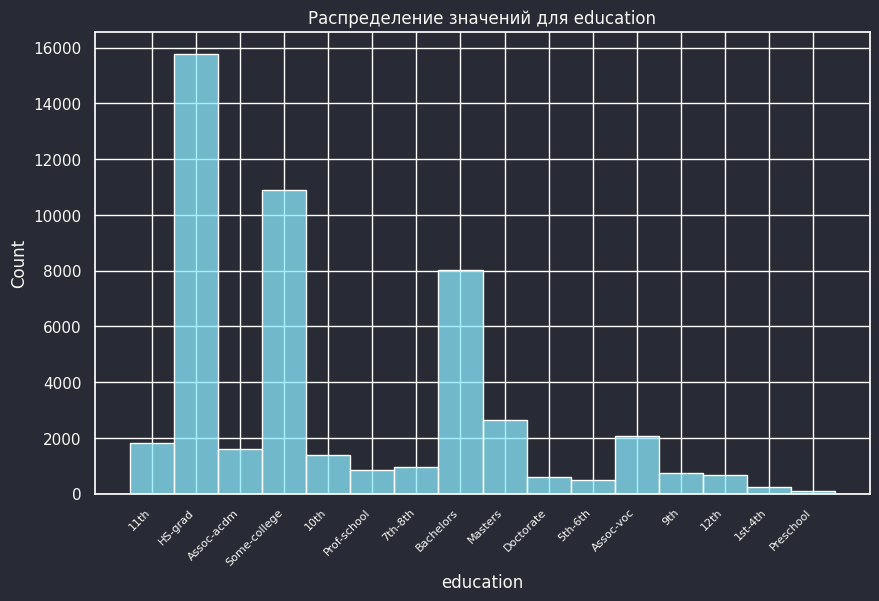

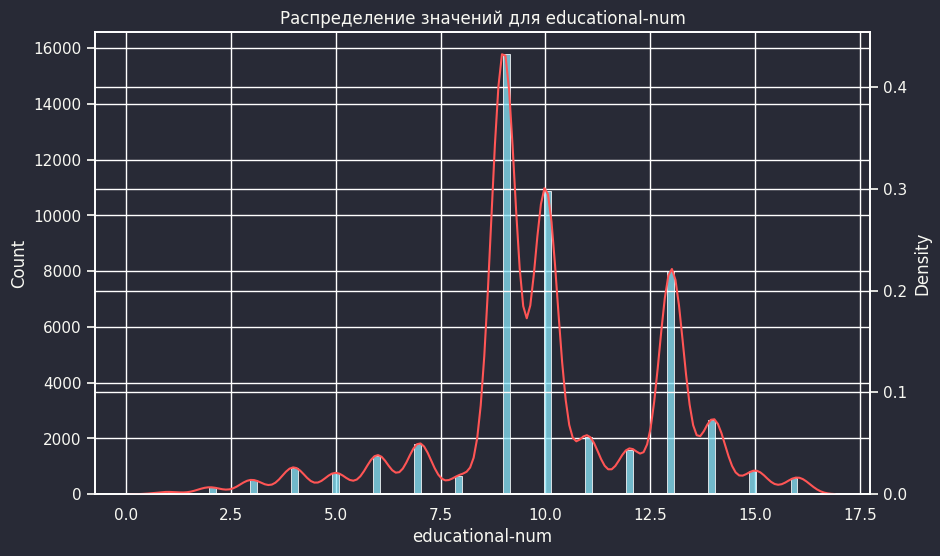

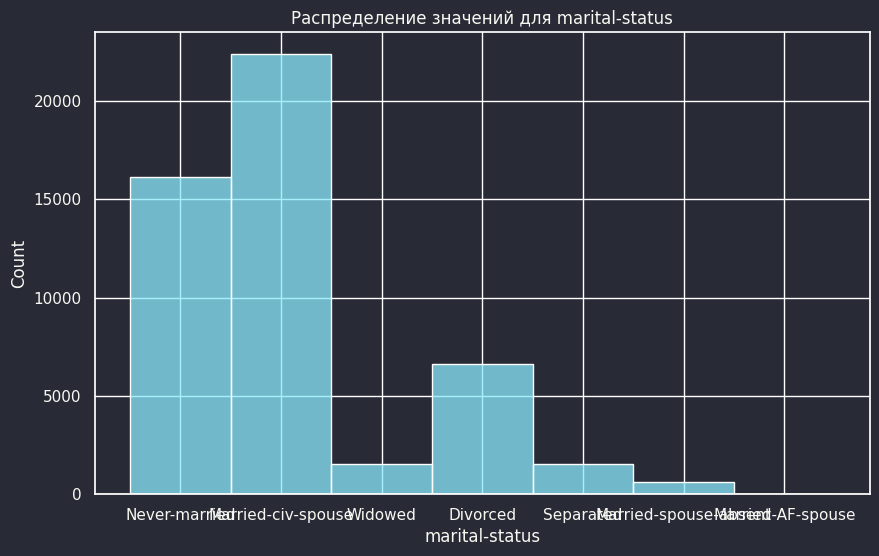

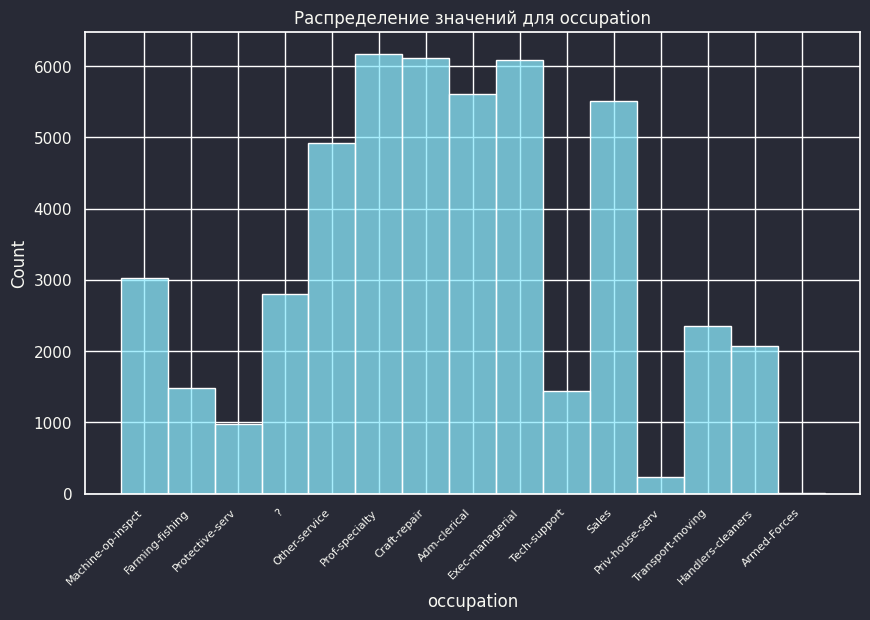

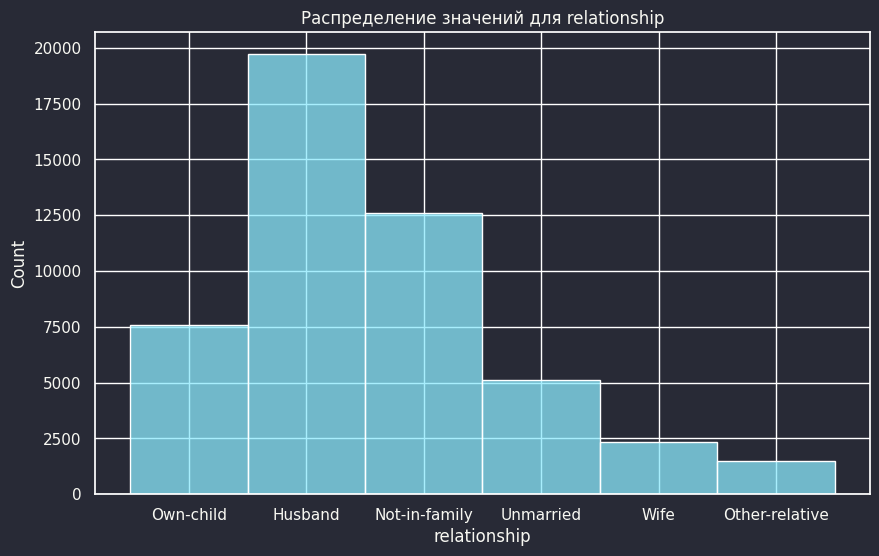

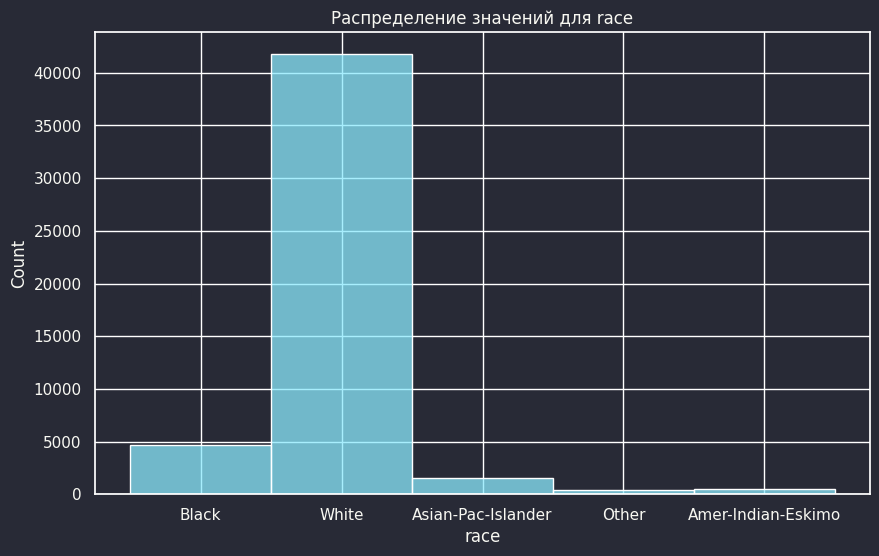

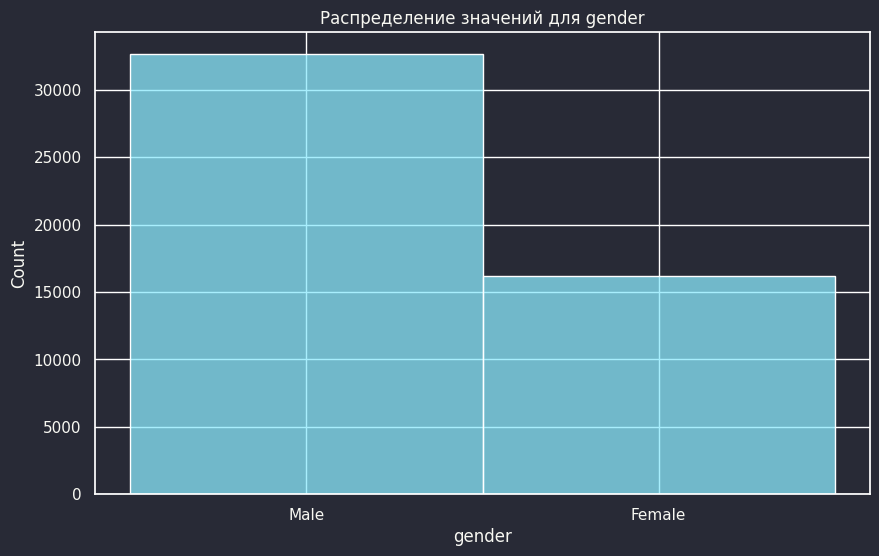

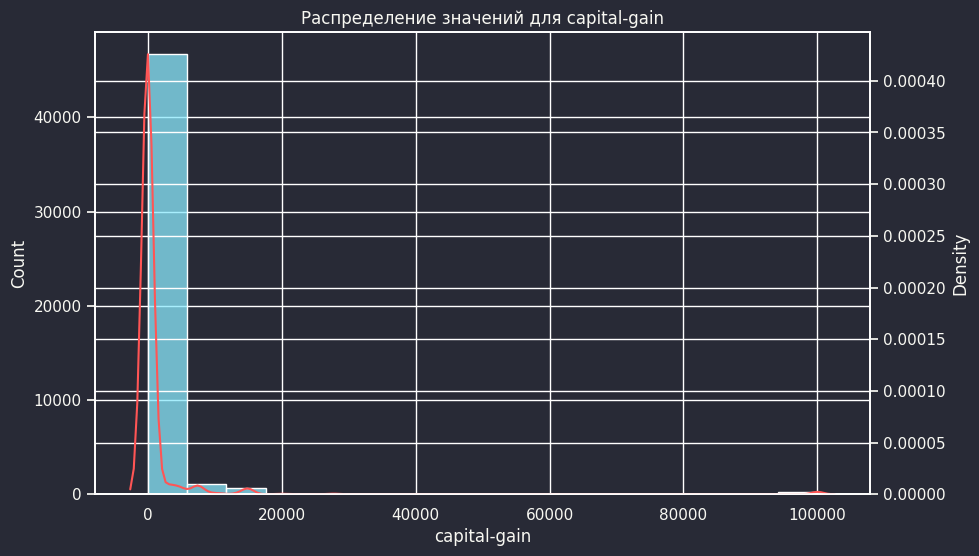

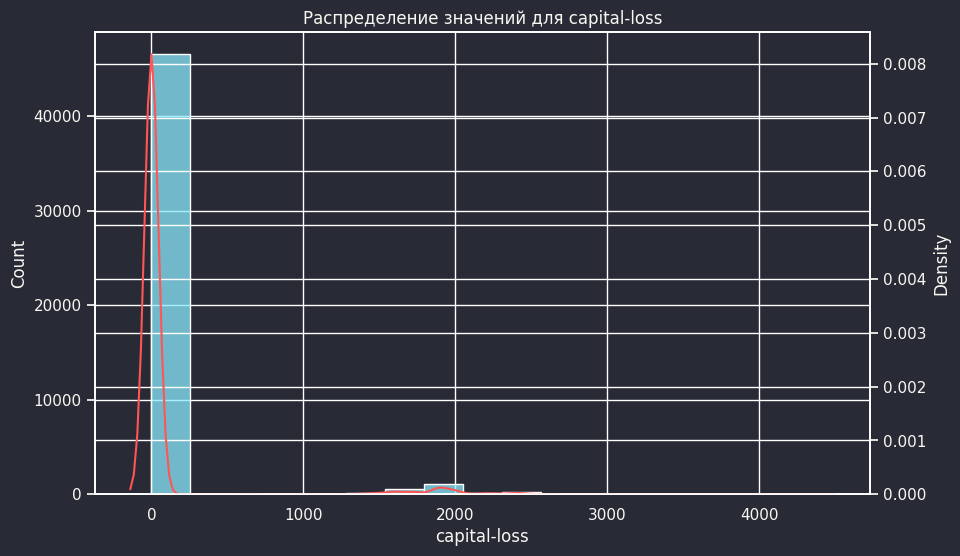

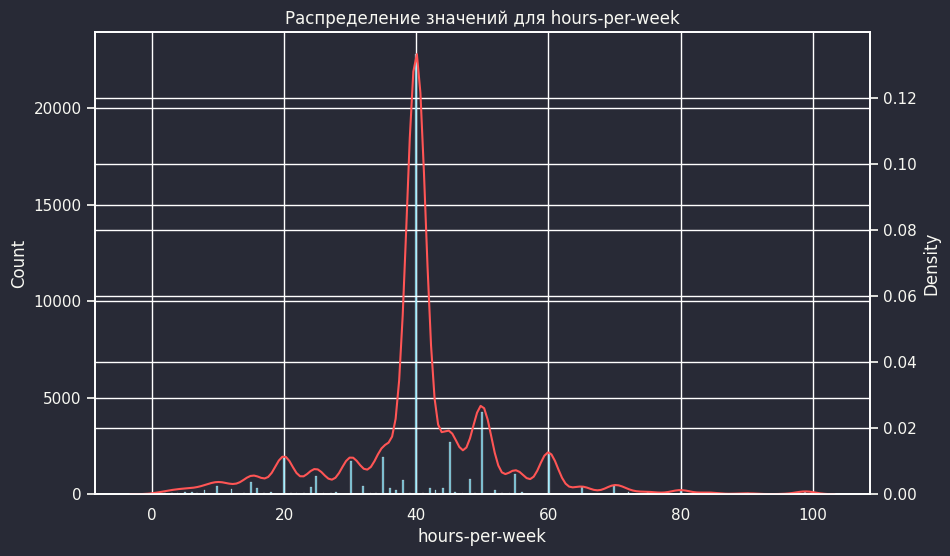

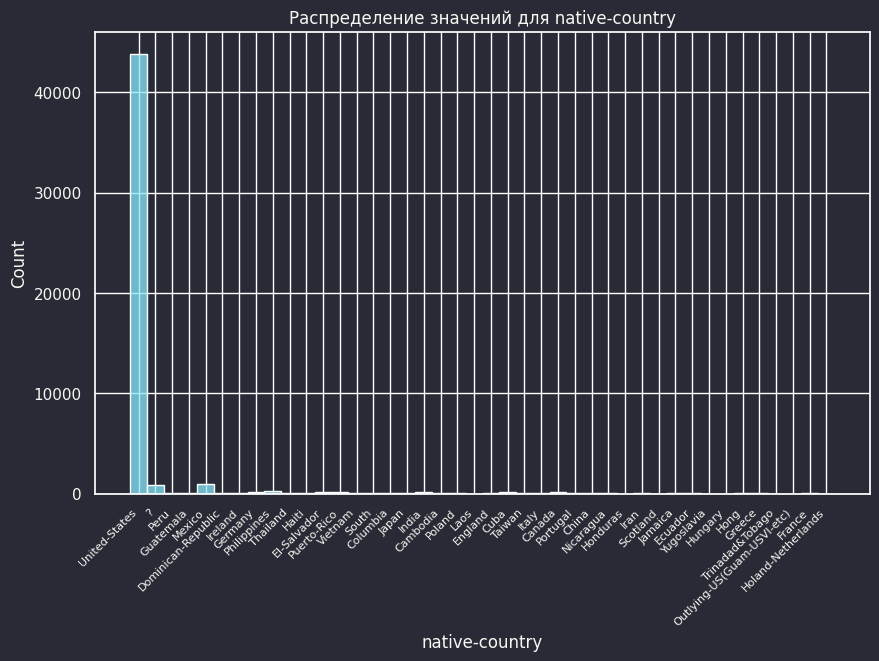

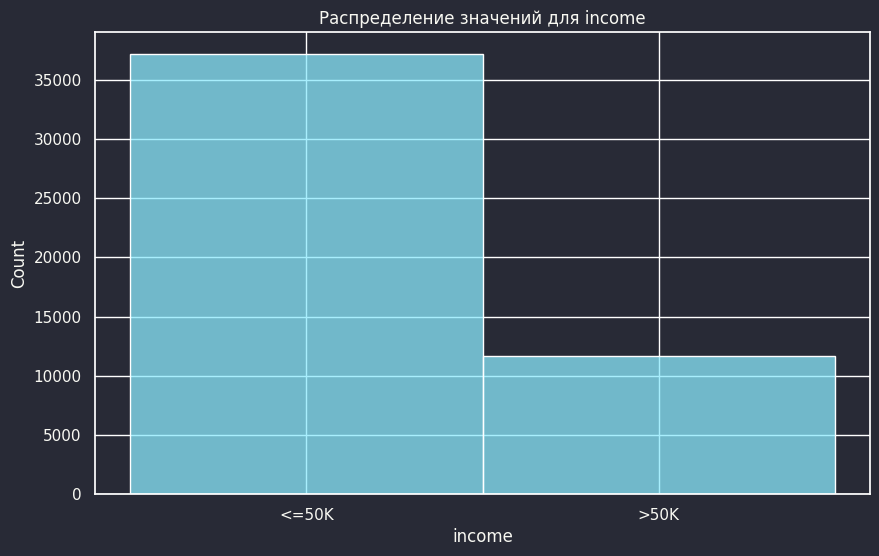

In [ ]:
for col in df.columns:
    plt.figure(figsize=(10, 6))
    ax1 = sns.histplot(df[col].dropna(), kde=False, color=dracula_palette['cyan'])
    if pd.api.types.is_numeric_dtype(df[col]):
        ax2 = ax1.twinx()
        sns.kdeplot(df[col].dropna(), color=dracula_palette['red'], ax=ax2)
    plt.title(f'Распределение значений для {col}', color=dracula_palette['foreground'])
    if col in ['native-country', 'education', 'workclass', 'material-status', 'occupation']:
        plt.xticks(rotation=45, ha='right')
        plt.gca().set_xticks(plt.gca().get_xticks())
        plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=8)
    plt.show()
    plt.close();

1. 'age':

Правостороннее (ассиметричное) скошенное распределение, с пиком около 40 лет, что свидетельствует о том, что в данных преобладают люди среднего возраста;


2. 'workclass':

В исследуемых данных частный сектор доминирует, государственная служба также представлена, но в меньшей степени, присутствует небольшое количество работающих без оплаты и никогда не работавших, что свидетельствует о разнообразии вида рабочего класса в выборке;


3. 'fnlwgt':

Логарифмически нормальное распределение, т.к. имеет значительные отклонения от симметричной формы, а также присутствует короткий правосторонний "хвост";

4. 'education':

Большинство людей в выборке имеют образование "HS-grad" (средняя школа) и "Some-college" (неполное высшее образование);

5. 'education-num':

Распределение является многомодальным с преобладающими пиками около 9, 10 и 13. Значения образовательного уровня сконцентрированы в определенных точках, что свидетельствует о наличии дискретных категорий;

6. 'marital-status':

Неравномерное распределение.Наиболее частое  значение: Married-civ-spouse, свидетельствующее о том, что в выборке преобладают люди, состоящие в официальном браке;

7. 'occupation':

Наибольшее количество людей занято в следующих сферах:


  *   Prof-specialty (профессиональная специализация): пик, свидетельствующий о выском спросе (преобладании) квалифицированных специалистов;

  *   Craft-repair (ремесло и ремонт);

  *   Exec-managerial (исполнительная и управленческая работа).

8. 'relationship':

В данных чаще всего встречаются семейные мужчины;

9. 'race':

Данные неравномерны: доля белых людей существенно выше, чем у иных рас;

10. 'gender':

Преобладание "Male" (мужской пол) в данных, в отличии "Female" (женский пол);

11. 'capital-gain':

Асимметричное распределение с правосторонним "хвостом", свидетельствующее о том, что большинство опрошенных не имели значительного капитального дохода, в то время как небольшое количество людей получили значительный доход;

12. 'capital-loss':

Асимметричное распределение с положительным перекосом. Правосторонний "хвост" распределения указывает на наличие небольшого количества опрошенных, которые понесли потери, и эти потери могут быть достаточно значительными, так как "хвост" простирается до значений более 4000;

13. 'hours-per-week':

Бимодальное распределение с пиками около 40 часов и 20 часов в неделю. Можно предположить, что присутствуют две основные группы: работающие полный рабочий день и работающие с частичной занятостью;

14. 'native-country':

Распределение неравномерное: большинство опрошенных приходится на США, остальные страны представлены в значительно меньшей степени;

15. 'income' (целевая переменная):

Большинство людей в выборке имеют доход <=50K (ниже или равно 50 тысячам).



Заменим пропуски, которые отображены символом '?' на NA для удобства.Подсчитаем количество пропусков в данных

In [ ]:
df = df.replace('?', pd.NA)

In [ ]:
null_values = df[df.isna().any(axis=1)]
null_values

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4,18,<NA>,103497,Some-college,10,Never-married,<NA>,Own-child,White,Female,0,0,30,United-States,<=50K
6,29,<NA>,227026,HS-grad,9,Never-married,<NA>,Unmarried,Black,Male,0,0,40,United-States,<=50K
13,58,<NA>,299831,HS-grad,9,Married-civ-spouse,<NA>,Husband,White,Male,0,0,35,United-States,<=50K
19,40,Private,85019,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,<NA>,>50K
22,72,<NA>,132015,7th-8th,4,Divorced,<NA>,Not-in-family,White,Female,0,0,6,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48811,35,<NA>,320084,Bachelors,13,Married-civ-spouse,<NA>,Wife,White,Female,0,0,55,United-States,>50K
48812,30,<NA>,33811,Bachelors,13,Never-married,<NA>,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
48820,71,<NA>,287372,Doctorate,16,Married-civ-spouse,<NA>,Husband,White,Male,0,0,10,United-States,>50K
48822,41,<NA>,202822,HS-grad,9,Separated,<NA>,Not-in-family,Black,Female,0,0,32,United-States,<=50K


Также, следует обратить внимание на признаки 'capital-gain' и 'capital-loss', которые содержат нулевые значения:

 вероятнее всего, что эти данные отражают отсутствие потери капитала

In [ ]:
df_null = df.isna().sum()
df_null

,0
age,0
workclass,2799
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,2809
relationship,0
race,0
gender,0


Пропуски содержаться в следующих категориальных признаках:
1.     workclass       - 2799 пропусков;
2.     occupation      - 2809 пропусков;
3.     native-country	 - 857 пропусков;

Всего значений с пропусками - 48842.


**Построим матрицу пропусков**

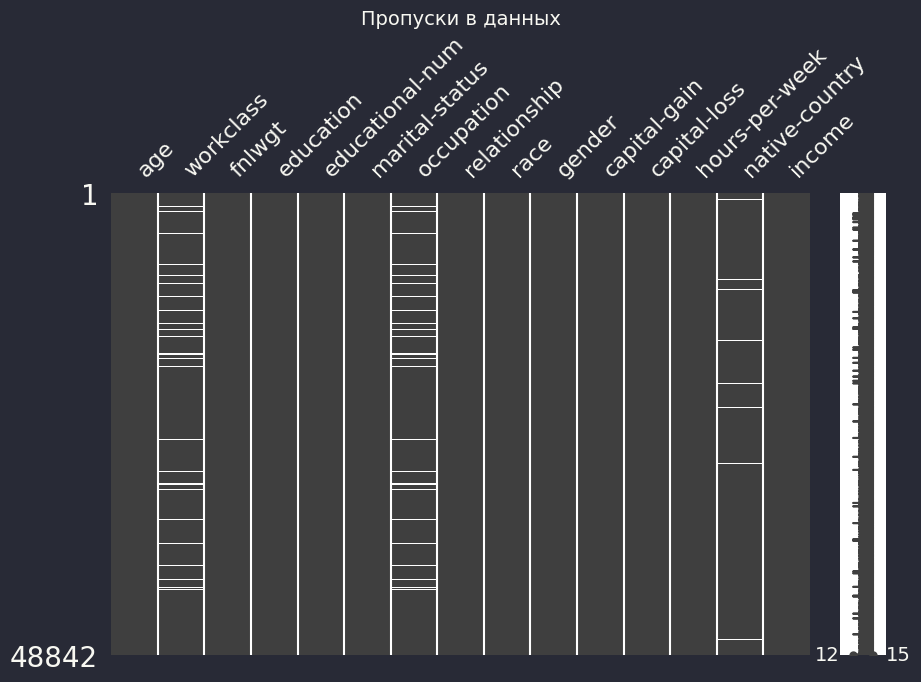

In [ ]:
msno.matrix(df)
plt.title('Пропуски в данных', fontsize=14, color=dracula_palette['foreground'])
plt.gcf().set_size_inches(10, 6)
plt.show();

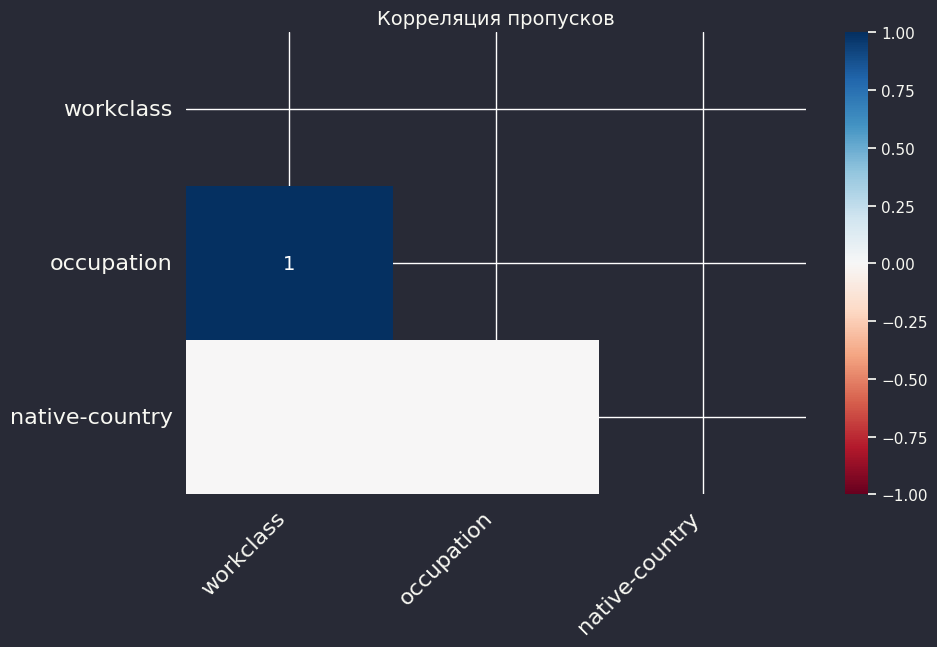

In [ ]:
msno.heatmap(df)
plt.title('Корреляция пропусков', fontsize=14, color=dracula_palette['foreground'])
plt.gcf().set_size_inches(10, 6)
plt.show()

Между 'workclass' и 'occupation' наблюдается высокая положительная корреляция (1), что свидетельствует о том, что с высокой вероятностью наличие пропусков хотя бы в одном из этих признаков будет аналогично пропускам в ином.

Естественно, если не известен рабочий класс человека (допустим, отказался представлять информацию), то зачастую: не сообщил и род своей деятельности

**Визуализируем древовидную диаграмму пропусков**

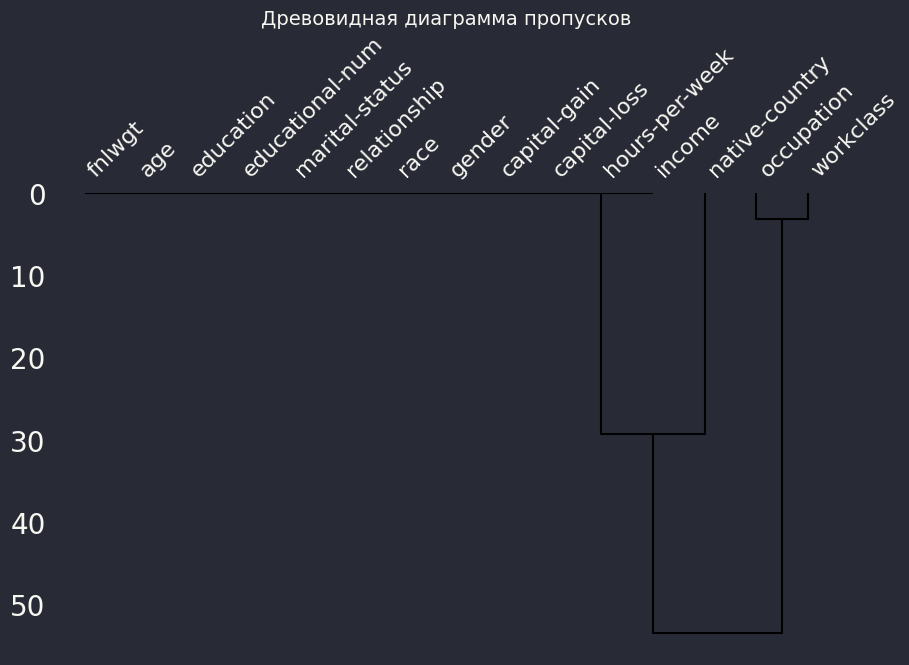

In [ ]:
msno.dendrogram(df)
plt.title('Древовидная диаграмма пропусков', fontsize=14, color=dracula_palette['foreground'])
plt.gcf().set_size_inches(10, 6)
plt.show();

Наблюдаются пропуски у признаков 'hours-per-week' и 'income'. Возможно, что по некоторым опрашиваемым отсутствует информация о количестве отработанных часов в неделю из-за неполноты информации о заработке.


Вероятно, что наличие пропусков в национальности способно привести к отсутствию данных о профессии и социальном классе.

In [ ]:
workclass = df['workclass'].value_counts()
workclass

,count
workclass,
Private,33906
Self-emp-not-inc,3862
Local-gov,3136
State-gov,1981
Self-emp-inc,1695
Federal-gov,1432
Without-pay,21
Never-worked,10


Наблюдается явное преобладание частного сектора, указывающее на то, что большинство людей работают в частном секторе, что характерно для многих стран с рыночной экономикой (33906)

In [ ]:
occupation = df['occupation'].value_counts()
occupation

,count
occupation,
Prof-specialty,6172
Craft-repair,6112
Exec-managerial,6086
Adm-clerical,5611
Sales,5504
Other-service,4923
Machine-op-inspct,3022
Transport-moving,2355
Handlers-cleaners,2072


Наибольшее количество работников занято в профессионально-специализированной сфере (6172)

In [ ]:
native_country = df['native-country'].value_counts()
native_country

,count
native-country,
United-States,43832
Mexico,951
Philippines,295
Germany,206
Puerto-Rico,184
Canada,182
El-Salvador,155
India,151
Cuba,138


Подавляющее большинство респондентов (43832) родом из США. Следовательно,выборка не является репрезентативной для мирового населения, а скорее отражает ситуацию конкретной страны (как с людьми, которые родом из США, так и иммигрантов)

***Построим гистограмму, чтобы увидеть распределение пропусков по столбцам***

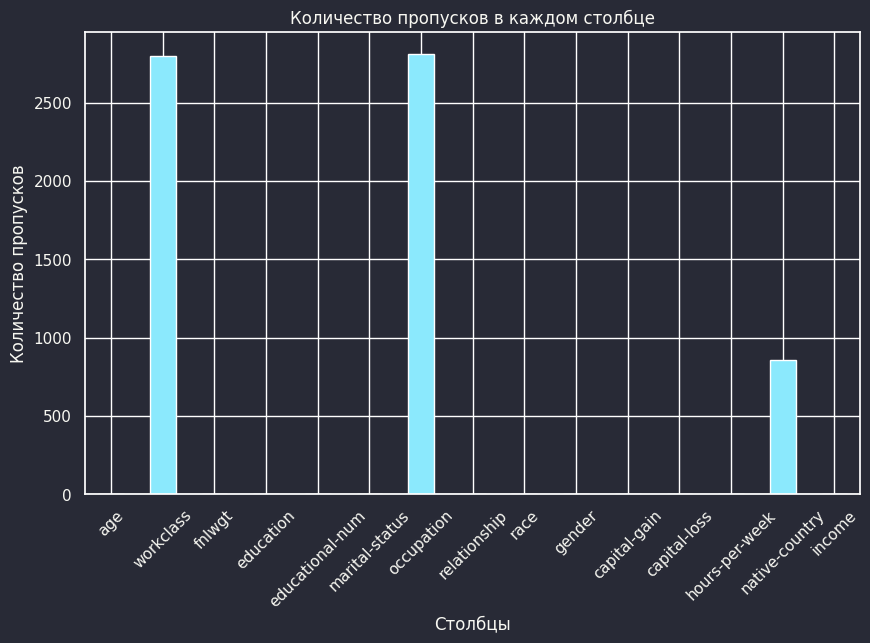

In [ ]:
plt.figure(figsize=(10, 6))
df_null.plot(kind='bar', color=dracula_palette['cyan'])
plt.title('Количество пропусков в каждом столбце', color=dracula_palette['foreground'])
plt.xlabel('Столбцы', color=dracula_palette['foreground'])
plt.ylabel('Количество пропусков', color=dracula_palette['foreground'])
plt.xticks(rotation=45, color=dracula_palette['foreground'])
plt.yticks(color=dracula_palette['foreground'])
plt.show();

Пропуски в workclass и occupation составляют 2799 и 2809 соответственно(около 5 - 6 %)

Пропуски в native-country составляют 857 (около 2 %)

Суммарно 8 % пропусков



***Построим box-plot, чтобы увидеть, как пропуски в определенных столбцах влияют на целевую переменную income***

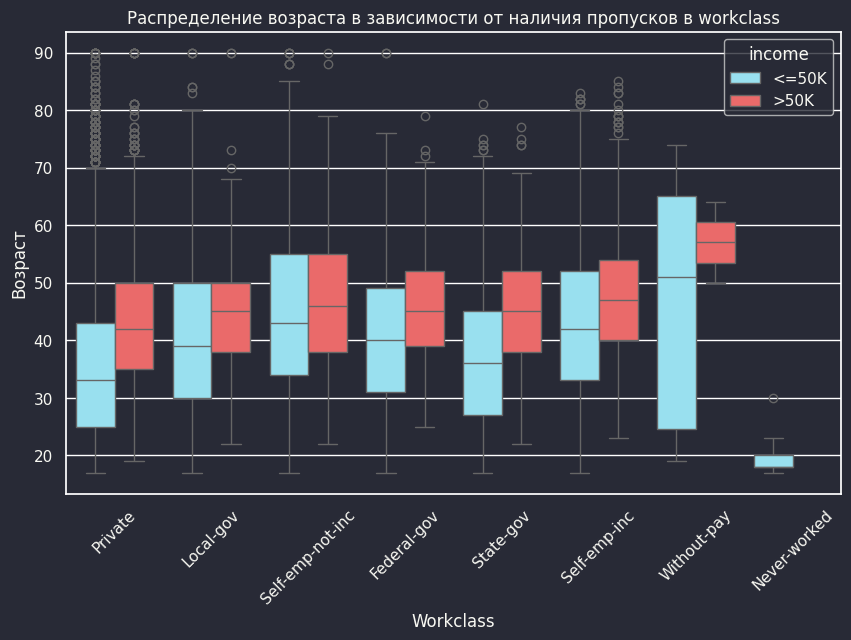

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['workclass'], y=df['age'], hue=df['income'], data=df.fillna('Missing'), palette=[dracula_palette['cyan'], dracula_palette['red']])
plt.title('Распределение возраста в зависимости от наличия пропусков в workclass')
plt.xlabel('Workclass')
plt.ylabel('Возраст')
plt.xticks(rotation=45 )
plt.show();

Люди, зарабатывающие более 50k, как правило, старше, чем те, кто зарабатывает менее 50k


В Private, Local-gov и "State-gov" средний возраст в двух группах дохода достаточно близок


В Self-emp-not-inc, Federal-gov и Self-emp-inc наблюдается, что средний возраст в группе с доходом более 50k незначительно выше


Важно отметить, что в некоторых категориях признака workclass есть значительные различия в среднем возрасте людей в зависимости от дохода, что свидетельствует о влиянии workclass на доход

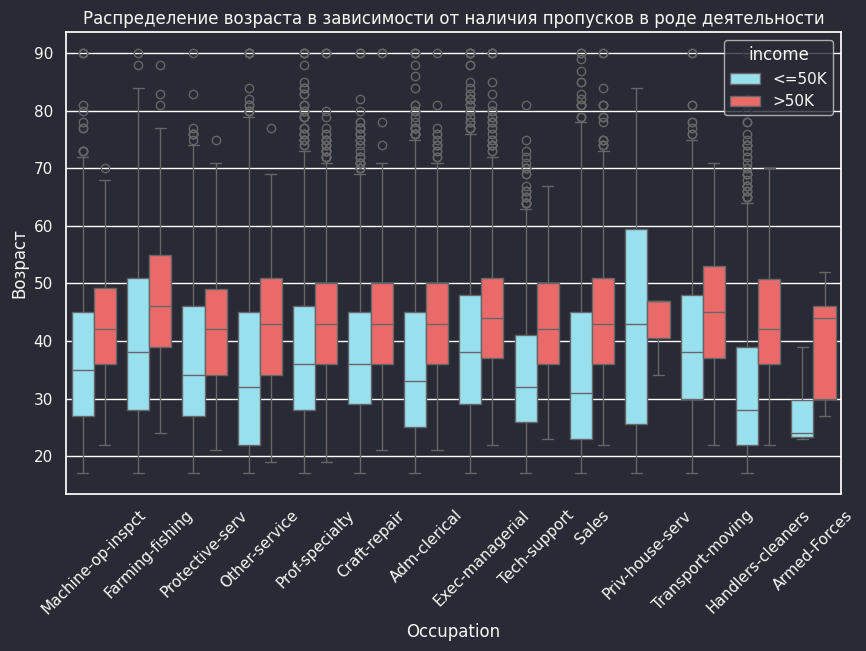

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['occupation'], y=df['age'], hue=df['income'], data=df.fillna('Missing'), palette=[dracula_palette['cyan'], dracula_palette['red']])
plt.title('Распределение возраста в зависимости от наличия пропусков в роде деятельности')
plt.xlabel('Occupation')
plt.ylabel('Возраст')
plt.xticks(rotation=45)
plt.show()

В зависимости от рода деятельности, в которой занят человек, его заработок разнится. В некоторых профессиях, таких как Exec-managerial, Sales, Armed-Forces, заработок выше 50К наблюдается у большего количества людей.

Однако есть и профессии, где наоборот, преобладает заработок ниже 50К, например, Machine-op-inspct, Farming-fishing, Handlers-cleaners.

Следовательно, можно полагать, что род деятельности влияет на целевую переменную (доход)

# ***Визуализация данных***

# Гистограмма распределения возраста

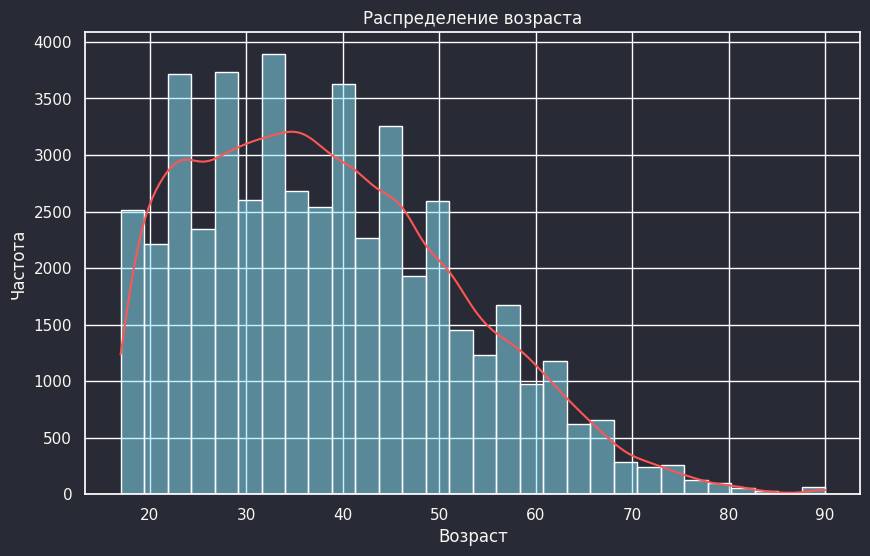

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True, color=dracula_palette['cyan'])
for line in plt.gca().get_lines():
    line.set_color(dracula_palette['red'])
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show();

Правостороннюя асимметрия, свидетельствуящая о том, что большинство людей находятся в более молодых возрастных группах, а количество людей уменьшается с увеличением возраста

# Распределение дохода

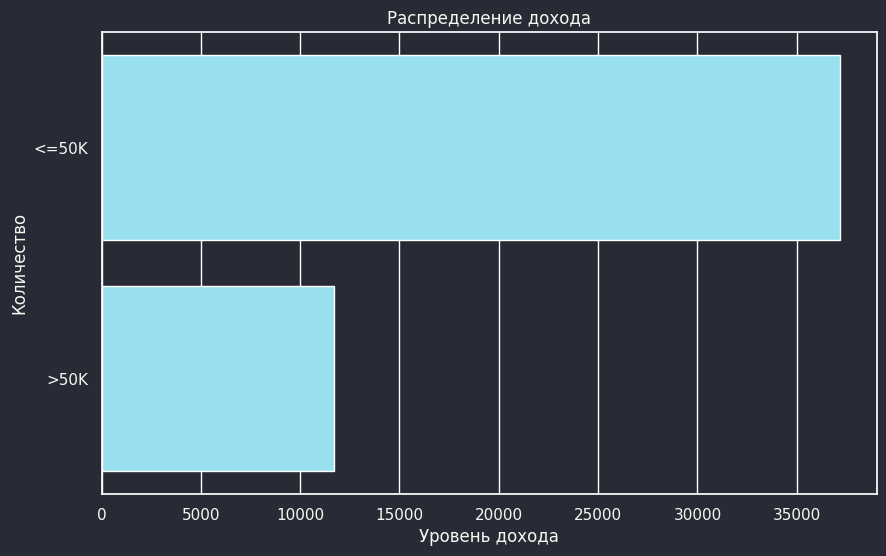

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(df['income'], color=dracula_palette['cyan'])
plt.title('Распределение дохода')
plt.xlabel('Уровень дохода')
plt.ylabel('Количество')
plt.show();

В данном наборе данных преобладают люди с  уровнем дохода ниже 50k

# Построение box-plot для возраста в зависимости от уровня дохода

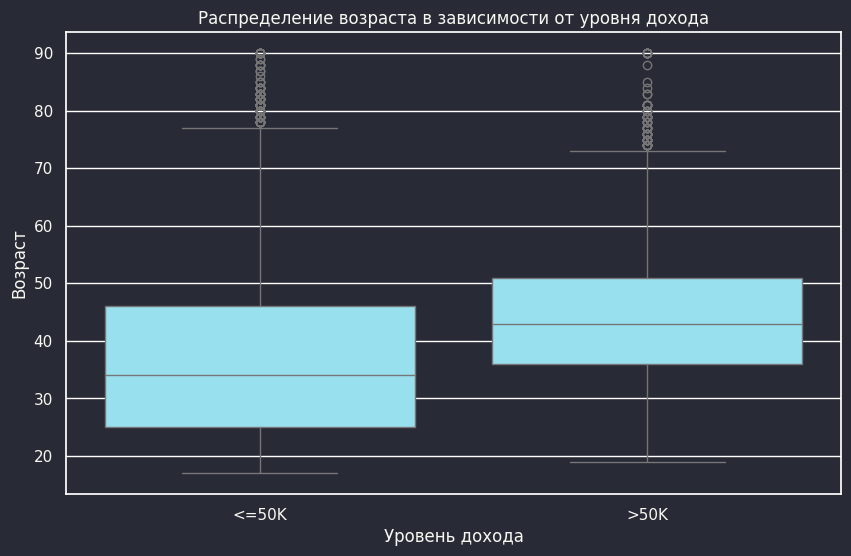

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['income'], y=df['age'], data=df, color=dracula_palette['cyan'])
plt.title('Распределение возраста в зависимости от уровня дохода')
plt.xlabel('Уровень дохода')
plt.ylabel('Возраст')
plt.show();

Медианный возраст людей с доходом больше 50К выше, чем у людей с доходом меньше 50К. Так же видно, что в группе с доходом больше 50К присутствуют выбросы, т.е. в этой группе есть люди в возрасте старше 80 лет.

# Построение box-plot для часов работы в неделю в зависимости от уровня дохода

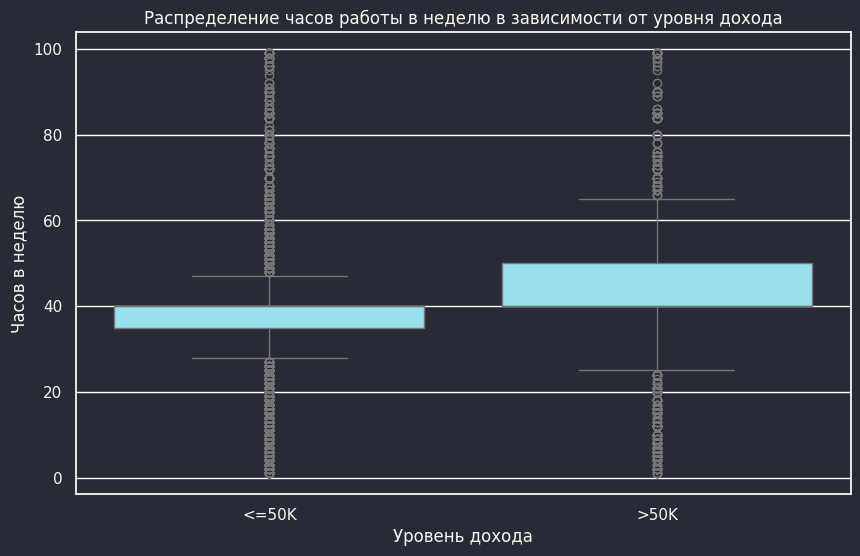

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = df['income'], y=df['hours-per-week'], data=df, color=dracula_palette['cyan'])
plt.title('Распределение часов работы в неделю в зависимости от уровня дохода')
plt.xlabel('Уровень дохода')
plt.ylabel('Часов в неделю')
plt.show()

Люди с более высоким уровнем дохода (выше 50K) работают больше часов в неделю, чем люди с более низким уровнем дохода (ниже 50K)

Существует несколько выбросов (outliers) в данных, особенно для людей с низким уровнем дохода, которые работают более 80 часов в неделю

# Работа с пропусками

Т.к. целевая перемення (income) зависит и от рода деятельности, так и типа занятости, а также по причине отсутствия ярко выроженной корреляции между признакми,так как все пропуски составляют 8 % суммарно, то удалять их не следует, из-за возможной потери ценной информации. Поэтому следует рассмотреть возможность заполнения пропусков.

В случае признака native-country, можно заполнить пропуски наиболее часто встречающимся значением, но существует риск смещения данных, если наиболее часто встречающееся значение не является репрезентативным (искажение распределения)

Для заполнения пропусков будет использоваться catboost, отлично справляющийся с заполнением пропусков у категориальных признаков. Подбор параметров для обучения будет осуществлен с помощью optuna

In [ ]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,<NA>,103497,Some-college,10,Never-married,<NA>,Own-child,White,Female,0,0,30,United-States,<=50K


# ***Заполнение пропусков с помощью CatBoost***

**Определеним порядок заполнения пропусков, от меньшего к большему числу пропусков у признаков**

In [ ]:
missing_order = ['native-country', 'workclass', 'occupation']

**Создадим копию данных для заполнения**

In [ ]:
df_cat = df.copy()

**Придадим NA (пропускам) категориальный вид**

In [ ]:
df_cat = df_cat.fillna('missing')
df_cat

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,missing,103497,Some-college,10,Never-married,missing,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


**Разделение на обучающую и тестовую выборку, обучение модели**

В обучающую выборку внесем данные не имеющие пропусков, а в тестовую - исключительно содержащие пропущенные значения, порядок заполнения регулируется **missing_order**, что позволит минимализировать возможность некорректного заполнения. Для подбора гиперпараметров будет использоваться optuna

In [ ]:
def fill_missing_values(df_cat, feature):
    train_df = df_cat[df_cat[feature] != 'missing']
    test_df = df_cat[df_cat[feature] == 'missing']
    X_train = train_df.drop(columns=[feature])
    y_train = train_df[feature]
    X_test = test_df.drop(columns=[feature])
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
            'depth': trial.suggest_int('depth', 4, 12),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e2, log=True),
            'random_strength': trial.suggest_float('random_strength', 1e-5, 10, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 10, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'verbose': 0,
            'task_type': 'GPU'
        }
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
        y_pred = model.predict(X_test)
        return f1_score(y_train, model.predict(X_train), average='weighted')

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=15)
    best_params = study.best_params
    best_params['task_type'] = 'GPU'
    model = CatBoostClassifier(**best_params)
    model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
    df_cat.loc[df_cat[feature] == 'missing', feature] = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    f1 = f1_score(y_train, y_pred_train, average='weighted')
    print(f"Признак: {feature}, F1 Score: {f1}")
    return df_cat, f1


f1_scores = []
for feature in missing_order:
    df_cat, f1 = fill_missing_values(df_cat, feature)
    f1_scores.append(f1)

[I 2024-11-22 21:07:59,080] A new study created in memory with name: no-name-4fcc6fdf-70e9-4242-8ef1-554c6f3ef40e
[I 2024-11-22 21:09:58,429] Trial 0 finished with value: 0.884830317096458 and parameters: {'iterations': 508, 'learning_rate': 0.0020117508990743125, 'depth': 9, 'l2_leaf_reg': 0.0005624918489421215, 'random_strength': 8.864369084467048, 'bagging_temperature': 4.940059309585131, 'border_count': 248}. Best is trial 0 with value: 0.884830317096458.
[I 2024-11-22 21:10:53,877] Trial 1 finished with value: 0.883215843165006 and parameters: {'iterations': 747, 'learning_rate': 0.39898238988922824, 'depth': 6, 'l2_leaf_reg': 0.0005625772970585378, 'random_strength': 4.601050021381549e-05, 'bagging_temperature': 8.216640525530723, 'border_count': 117}. Best is trial 0 with value: 0.884830317096458.
[I 2024-11-22 21:15:15,955] Trial 2 finished with value: 0.8898879790019795 and parameters: {'iterations': 363, 'learning_rate': 0.0024892110257807437, 'depth': 11, 'l2_leaf_reg': 2.21

Признак: native-country, F1 Score: 0.9501510688789577


[I 2024-11-22 21:44:12,278] Trial 0 finished with value: 0.700084981734377 and parameters: {'iterations': 974, 'learning_rate': 0.0034907034214999126, 'depth': 12, 'l2_leaf_reg': 0.16718720028916517, 'random_strength': 0.00016698826470434134, 'bagging_temperature': 0.010932990715304914, 'border_count': 151}. Best is trial 0 with value: 0.700084981734377.
[I 2024-11-22 21:44:22,042] Trial 1 finished with value: 0.6688117215971772 and parameters: {'iterations': 609, 'learning_rate': 0.006615658362007462, 'depth': 6, 'l2_leaf_reg': 0.00539756497980061, 'random_strength': 0.0036452209465215202, 'bagging_temperature': 0.494089694532404, 'border_count': 219}. Best is trial 0 with value: 0.700084981734377.
[I 2024-11-22 21:46:08,591] Trial 2 finished with value: 0.7982338042251708 and parameters: {'iterations': 882, 'learning_rate': 0.21379408949275192, 'depth': 11, 'l2_leaf_reg': 9.796076366669393, 'random_strength': 0.003229947198211481, 'bagging_temperature': 0.03260883413574039, 'border_c

Признак: workclass, F1 Score: 0.8565677132957786


[I 2024-11-22 21:58:29,626] Trial 0 finished with value: 0.6652510365928302 and parameters: {'iterations': 541, 'learning_rate': 0.2960542574484186, 'depth': 11, 'l2_leaf_reg': 0.015208889284093158, 'random_strength': 0.09143555523430735, 'bagging_temperature': 2.066522661905878, 'border_count': 193}. Best is trial 0 with value: 0.6652510365928302.
[I 2024-11-22 21:58:35,565] Trial 1 finished with value: 0.168784958567568 and parameters: {'iterations': 372, 'learning_rate': 0.009311008239203644, 'depth': 5, 'l2_leaf_reg': 2.7166070620970166e-05, 'random_strength': 0.023057056913592864, 'bagging_temperature': 0.12210601285171573, 'border_count': 86}. Best is trial 0 with value: 0.6652510365928302.
[I 2024-11-22 22:01:18,723] Trial 2 finished with value: 0.38335367842304946 and parameters: {'iterations': 420, 'learning_rate': 0.0053200166701208255, 'depth': 12, 'l2_leaf_reg': 6.470704217499175e-05, 'random_strength': 0.010638718123326412, 'bagging_temperature': 3.1649756028336826, 'borde

Признак: occupation, F1 Score: 0.6649099458946208


**Оценка модели, визуализируем F1**

Text(0.5, 0, 'Признак')

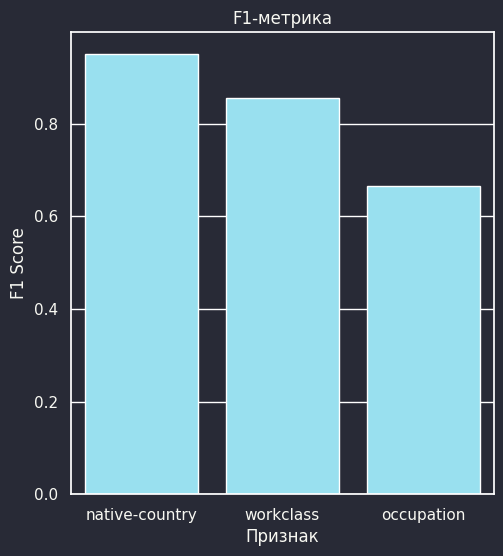

In [ ]:
features = missing_order


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=features, y=f1_scores)
plt.title('F1-метрика')
plt.ylabel('F1 Score')
plt.xlabel('Признак')

Модель эффективно компенсирует недостающие значения для «native-country» с высоким показателем F1 (0.95), что говорит о хорошо настроенных гиперпараметрах. Однако для «workclass» (F1 = 0.856) и «occupation» (F1 ≈ 0.69) показатели ниже, что говорит о потенциальных проблемах в прогнозировании этих признаков. Данные различия могут быть обусловлены различиями в распределении данных, важности признаков или подгонке модели.Но, в целом, результаты, полученные по итогам заполнения пропусков - вполне оптимальны.


Результаты заполнения можно улучшить, добаив большее кол-во n_trials, чтобы опробировать множество комбинаций гиперпараметров.

**После заполнения, проверим остались ли пропуски**

In [ ]:
df_cat_null = df_cat.isna().sum()
df_cat_null

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [ ]:
cat_cols = df_cat.select_dtypes(include='category').columns
mask = df_cat[cat_cols].isin(['missing']).any(axis=1)
result = df_cat[mask]
result

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income


Все пропуски успешно заполнены

**Перенесем заполненные значения в исходный набор данных**

In [ ]:
df.update(df_cat)
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,Private,103497,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# ***Преобразование категориальных признаков***

In [ ]:
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

**Разделение на обучающую и тренировочную выборки**

В данном случае, нам необходимо предсказать целевую переменную income

In [ ]:
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#**Обучение модели логистической регрессии**

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

# **Обучение модели SVM**

In [ ]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

**Вычислим точность модели логистической регрессии**

In [ ]:
log_reg_accuracy = log_reg.score(X_test, y_test)
print(f'Точность логистической регрессии: {log_reg_accuracy:.2f}')

Точность логистической регрессии: 0.81


**Вычислим точность SVM модели**

In [ ]:
svm_accuracy = svm_model.score(X_test, y_test)
print(f'Точность SVM: {svm_accuracy:.2f}')

Точность SVM: 0.80


**Визуализируем точность**

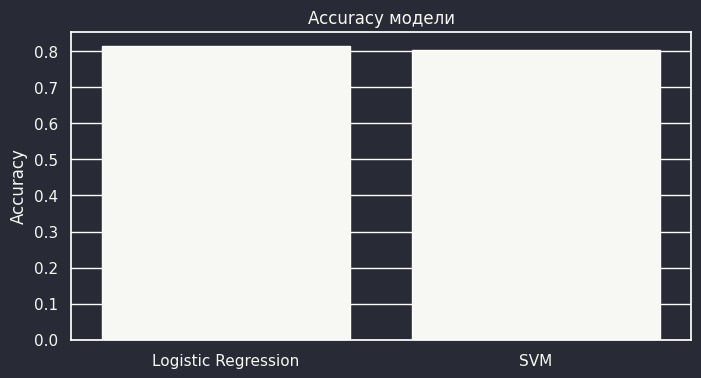

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x=['Logistic Regression', 'SVM'], y=[log_reg_accuracy, svm_accuracy], color=dracula_palette['foreground'])
plt.ylabel('Accuracy')
plt.title('Accuracy модели')
plt.show()

**Вычислим ROC-AUC**

In [ ]:
y_pred_log_reg = log_reg.predict_proba(X_test)[:, 1]
log_reg_roc_auc = roc_auc_score(y_test, y_pred_log_reg)
print(f'ROC AUC логистической регрессии: {log_reg_roc_auc:.2f}')


y_pred_svm = svm_model.predict_proba(X_test)[:, 1]
svm_roc_auc = roc_auc_score(y_test, y_pred_svm)
print(f'ROC AUC SVM: {svm_roc_auc:.2f}')

ROC AUC логистической регрессии: 0.82
ROC AUC SVM: 0.61


# **Итоговый вывод:**

Благодаря заполнению пропусков с помощью catboost и поиска оптимальных гиперпараметров для обучения удалось повысить точность предсказаний как для SVM, так и для логистической регрессии, уменьшив возможность искажения предсказаний (допустим, заполняя средним или медианой).Улучшить результаты, возможно с увеличением значения n_trials = 50 или 100.



Разница в точности логистической регресии (0.81) и SVM (0.80) - незначительная, но логистическая регрессия чуть лучше, но метрика ROC AUC у лог. регрессии (0.82) значительно превосходит SVM (0.61), что свидетельствует о способности первой к более точному прогнозированию (бинарной классификации).Таким образом, логистическая регрессия предпочтительнее в данном кейсе.

In [ ]:
!nvidia-smi

Fri Nov 22 22:29:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              32W /  70W |    107MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--